In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import gensim
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

In [2]:
df = pd.read_csv("train.csv")

In [3]:
X = df[['question1', 'question2']]

In [4]:
y = df.is_duplicate

In [5]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=808)

### Preprocessing (keras)

In [6]:
# tokenize
tok = Tokenizer()
tok.fit_on_texts(list(df['question1'].values.astype(str))+list(df['question2'].values.astype(str)))

In [7]:
# pad and sequence - training
X_train_q1 = tok.texts_to_sequences(X_train['question1'].values.astype(str))
X_train_q1 = pad_sequences(X_train_q1, maxlen = 30, padding='post')

# X_train_q2 = tokenizer.texts_to_sequences(np.array(listq2))
X_train_q2 = tok.texts_to_sequences(X_train['question2'].values.astype(str))
X_train_q2 = pad_sequences(X_train_q2, maxlen = 30, padding='post')

In [8]:
# pad and sequence - testing
X_test_q1 = tok.texts_to_sequences(X_test['question2'].values.astype(str))
X_test_q1 = pad_sequences(X_test_q1,maxlen = 30, padding='post')

X_test_q2 = tok.texts_to_sequences(X_test['question1'].values.astype(str))
X_test_q2 = pad_sequences(X_test_q2, maxlen = 30, padding='post')

In [9]:
word_index = tok.word_index

### Embeddings using word2vec

In [10]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [11]:
vocab = dict([(k, v.index) for k, v in w2v.vocab.items()])

In [12]:
embedding_matrix = np.random.random((len(word_index)+1, 300))
for word, i in word_index.items():
    try:
        embedding_vector = w2v.self[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except:
        pass

### LSTM

In [13]:
# Model for Q1

model_q1 = tf.keras.Sequential()
model_q1.add(Embedding(input_dim = len(word_index)+1,
                       output_dim = 300,
                      weights = [embedding_matrix],
                      input_length = 30))
model_q1.add(LSTM(128, activation = 'tanh', return_sequences = True))
model_q1.add(Dropout(0.2))
model_q1.add(LSTM(128, return_sequences = True))
model_q1.add(LSTM(128))
model_q1.add(Dense(60, activation = 'tanh'))
model_q1.add(Dense(2, activation = 'sigmoid'))

In [14]:
# Model for Q2

model_q2 = tf.keras.Sequential()
model_q2.add(Embedding(input_dim = len(word_index)+1,
                       output_dim = 300,
                      weights = [embedding_matrix],
                      input_length = 30))
model_q2.add(LSTM(128, activation = 'tanh', return_sequences = True))
model_q2.add(Dropout(0.2))
model_q2.add(LSTM(128, return_sequences = True))
model_q2.add(LSTM(128))
model_q2.add(Dense(60, activation = 'tanh'))
model_q2.add(Dense(2, activation = 'sigmoid'))

In [15]:
# Merging the output of the two models,i.e, model_q1 and model_q2
mergedOut = Multiply()([model_q1.output, model_q2.output])

mergedOut = Flatten()(mergedOut)
mergedOut = Dense(100, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(50, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(2, activation = 'sigmoid')(mergedOut)

In [16]:
new_model = Model([model_q1.input, model_q2.input], mergedOut)
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
                 metrics = ['acc'])
history = new_model.fit([X_train_q1,X_train_q2],y_train, validation_split=0.33, batch_size = 2000, epochs = 50)

Epoch 1/50
102/102 [==============================] - 18s 123ms/step - loss: 0.6506 - acc: 0.6294 - val_loss: 0.6228 - val_acc: 0.6297
Epoch 2/50
102/102 [==============================] - 11s 107ms/step - loss: 0.5965 - acc: 0.6663 - val_loss: 0.5658 - val_acc: 0.7174
Epoch 3/50
102/102 [==============================] - 11s 106ms/step - loss: 0.5375 - acc: 0.7309 - val_loss: 0.5368 - val_acc: 0.7298
Epoch 4/50
102/102 [==============================] - 11s 107ms/step - loss: 0.5073 - acc: 0.7504 - val_loss: 0.5304 - val_acc: 0.7343
Epoch 5/50
102/102 [==============================] - 11s 113ms/step - loss: 0.4860 - acc: 0.7635 - val_loss: 0.5364 - val_acc: 0.7370
Epoch 6/50
102/102 [==============================] - 11s 108ms/step - loss: 0.4680 - acc: 0.7737 - val_loss: 0.5481 - val_acc: 0.7170
Epoch 7/50
102/102 [==============================] - 11s 107ms/step - loss: 0.4493 - acc: 0.7827 - val_loss: 0.5310 - val_acc: 0.7403
Epoch 8/50
102/102 [==============================] - 1

In [17]:
y_pred = new_model.predict([X_test_q1, X_test_q2], batch_size=2000, verbose=1)

51/51 [==============================] - 3s 28ms/step


In [19]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

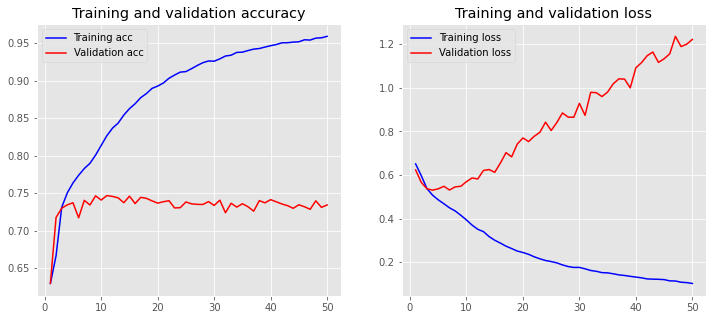

In [20]:
plot_history(history)

In [24]:
loss, accuracy = new_model.evaluate([X_train_q1,X_train_q2], y_train, batch_size=2000, verbose=0)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = new_model.evaluate([X_test_q1, X_test_q2], y_test, batch_size=2000, verbose=0)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8855
Testing Accuracy:  0.7024
